In [2]:
import PyPDF2
import stanfordnlp
import pickle
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import *
from tqdm import tqdm
import re
import random
import math
import matplotlib.pyplot as plt
import umap

In [3]:
_ = torch.manual_seed(0)

In [258]:
class TransformerSentence():
    def __init__(self, sentence_str, 
                 model=BertModel.from_pretrained('scibert-scivocab-uncased'), 
                 tokenizer=BertTokenizer.from_pretrained('scibert-scivocab-uncased')):
        
        self.raw_string = sentence_str
        self.model = model
        self.tokenizer = tokenizer
        self.summary = {}

        
    def write_summary(self, input_tokens=None, 
                      hidden_states=None, 
                      hidden_attentions=None,
                      print_tokens=True):
        
        if (input_tokens or hidden_states or hidden_attentions) is None:
            input_tokens, hidden_states, hidden_attentions = self.forward()
        
        # this replaces adds a "_{counter}" to the repreated tokens, so that 
        # they can be used uniquely as the keys for the embeddings dictionary
        input_tokens = TransformerSentence.make_unique(input_tokens)
        
        if print_tokens:
            print('Sentence Tokenization: ', input_tokens)
            
        # write summary into the object
        self.summary['input_tokens'] = input_tokens
        self.summary['states'] = hidden_states
        self.summary['attentions'] = hidden_attentions

        self.summary['token_embeddings'] = {input_token: hidden_states[:, i, :] 
                                            for i, input_token in enumerate(input_tokens)}
        
    def forward(self):
        encoded_inputs_dict = self.tokenizer.encode_plus(self.raw_string)
        input_ids = encoded_inputs_dict['input_ids']
        input_tensor = torch.tensor([input_ids])
        input_tokens = [self.tokenizer.decode(input_ids[j]).replace(' ', '') 
                        for j in range(len(input_ids))]
        
        final_attention, final_state, hidden_states_tup, hidden_attentions_tup = self.model(input_tensor)
        
        # stacking states and attentions along the first dimention (which corresponds to the batch when necessary)
        hidden_attentions = torch.cat(hidden_attentions_tup, dim=0) # 'layers', 'heads', 'queries', 'keys'
        hidden_states = torch.cat(hidden_states_tup, dim=0) # 'layers', 'tokens', 'embeddings'
        
        return input_tokens, hidden_states.detach(), hidden_attentions.detach()
    
    
    def attention_from_tokens(self, token1, token2, display=True):
        input_tokens = self.summary['input_tokens']
        
        if (token1 and token2) not in input_tokens:
            raise ValueError('One or both of the tokens introduced are not in the sentence!')
            
        idx1, idx2 = input_tokens.index(token1), input_tokens.index(token2)
        attention = self.summary['attentions'][:, :, idx1, idx2].numpy()
        if display:
            TransformerSentence.display_attention(attention, title=(token1, token2))
        return attention
    
    
    def attention_from_idx(self, i, j, display=True):
        attention = self.summary['attentions'][:, :, i, j].numpy()
        if display:
            TransformerSentence.display_attention(attention, title=f'Token idx: {(i, j)}')
        return attention
    
    def visualize_token_path(self, fit, tokens_to_follow=None, print_tokens=False):
        
        if tokens_to_follow is None:
            all_tokens = self.summary['input_tokens']
            regex = re.compile(r'^[a-zA-Z]')
            tokens_to_follow = [i for i in all_tokens if regex.search(i)]
            
        if print_tokens: print(tokens_to_follow)  
            
        colors = list(range(len(tokens_to_follow)))
        projections = []
        layer_depth = self.summary['states'].size()[0]

        for i in range(layer_depth):
            layer_embeddings = all_states[i, :, :]
            projection = fit.transform(layer_embeddings)
            projections.append(projection)

        data = np.stack(projections, axis=0)
        for token in tokens_to_follow:
            i = self.summary['input_tokens'].index(token)
            plt.plot(data[:,i,0], data[:,i,1], '-o', alpha=0.3)
            plt.annotate(s=token, xy=(data[0, i, 0], data[0, i, 1]))

        plt.show()
    
    
    def save(self, name, path='.'):
        with open(os.path.join(path, name), 'wb') as file:
            pickle.dump(self, file)
    
    
    @staticmethod
    def visualize_embedding(embedding, title=None, vmax=None, vmin=None):
        if (vmax or vmin) is None:
            vmax = max(embedding)
            vmin = min(embedding)
            
        N = embedding.size()[0]
        h = math.ceil(math.sqrt(N))
        # N = a*b where abs(a-b) is minimum
        while (N % h != 0):
            h -= 1
        w = int(N / h)
        visualization = embedding.reshape((h, w)).numpy()
        fig, ax = plt.subplots()
        im = ax.imshow(visualization, vmax=vmax, vmin=vmin)
        if title is not None:
            ax.set_title(title)
        plt.show()
    
    @staticmethod
    def display_attention(attention, title=None):
        fig, ax = plt.subplots()
        im = ax.imshow(attention, vmin=0., vmax=1.)
        if title is not None:
            ax.set_title(title)
        ax.set_xlabel('HEADS')
        ax.set_ylabel('LAYERS')
        plt.show()
    
    @staticmethod
    def load(name, path='.'):
        with open(os.path.join(path, name), 'rb') as file:
            SentenceObject = pickle.load(file)
        return SentenceObject
    
    @staticmethod
    def make_unique(L):
        unique_L = []
        for i, v in enumerate(L):
            totalcount = L.count(v)
            count = L[:i].count(v)
            unique_L.append(v + '_' + str(count+1) if totalcount > 1 else v)
        return unique_L

In [5]:
# Preloading models (this is the most costly)
BertBaseModel = BertModel.from_pretrained('bert-base-uncased')
BertBaseTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BertLargeModel = BertModel.from_pretrained('bert-large-uncased')
BertLargeTokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
SciBertModel = BertModel.from_pretrained('scibert-scivocab-uncased')
SciBertTokenizer = BertTokenizer.from_pretrained('scibert-scivocab-uncased')
SciBertBaseVocabModel = BertModel.from_pretrained('scibert-basevocab-uncased')
SciBertBaseVocabTokenizer = BertTokenizer.from_pretrained('scibert-basevocab-uncased')

In [259]:
raw_sentence = "Computer Vision: What is the difference between local descriptors and global descriptors"

scibert_sentence = TransformerSentence(raw_sentence,
                                       model=SciBertModel,
                                       tokenizer=SciBertTokenizer)
bert_sentence = TransformerSentence(raw_sentence,
                                    model=BertBaseModel,
                                    tokenizer=BertBaseTokenizer)
bert_large_sentence = TransformerSentence(raw_sentence,
                                          model=BertLargeModel,
                                          tokenizer=BertLargeTokenizer)

In [260]:
scibert_sentence.write_summary(print_tokens=False)
bert_sentence.write_summary(print_tokens=False)
bert_large_sentence.write_summary(print_tokens=False)

In [7]:
e1i =  scibert_sentence.summary['token_embeddings']['computer'][0,:]
e1f =  scibert_sentence.summary['token_embeddings']['computer'][-1,:]
e2i =  scibert_sentence.summary['token_embeddings']['vision'][0,:]
e2f =  scibert_sentence.summary['token_embeddings']['vision'][-1,:]


In [ ]:
_ = scibert_sentence.attention_from_tokens('what', 'difference', display=True)
_ = bert_sentence.attention_from_tokens('what', 'difference', display=True)

In [6]:
# Read input sequences from .txt file and put them in a list
with open("../datasets/quora_questions.txt") as f:
    text = f.read()
sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
try:
    sentences.remove('') # remove possible empty strings
except:
    None

In [264]:
scibert_sentences = []
ALL_EMBEDDINGS = []
for raw_sentence in tqdm(sentences):
    SentenceObj = TransformerSentence(raw_sentence,
                                      model=SciBertModel,
                                      tokenizer=SciBertTokenizer)
    SentenceObj.write_summary(print_tokens=False)
    scibert_sentences.append(SentenceObj)
    ALL_EMBEDDINGS.append(SentenceObj.summary['states'][0, :, :])
ALL_EMBEDDINGS = torch.cat(ALL_EMBEDDINGS, dim=0)

100%|██████████| 301/301 [00:42<00:00,  7.16it/s]


In [265]:
for i, sentence in enumerate(scibert_sentences):
    print(i, sentence.raw_string)

0 Are convolutional neural networks useful for tasks other than image classification?
1 Are non-causal temporal convolutions the equivalence of Bi-LSTM?
2 Are there any techniques, other than RNN/LSTM, to handle time series data?
3 Bayesian Inference: What is a Dirichlet process in layman's terms?
4 Can an objective account of statistical inference be based on frequentist methods and Bayesian methods?
5 Can Bayesian Network be combined with Deep Learning and/or reinforcement Learning to figure out causation?
6 Can deep neural networks learn the minimum function?
7 Can facial recognition tools be fooled?
8 Can recurrent neural networks with LSTM be used for time series prediction?
9 Can RNN be used for time series dynamic modelling?
10 If yes, how?
11 Can you explain the HMM algorithm?
12 Classification (machine learning): When should I use a K-NN classifier over a Naive Bayes classifier?
13 Computer Vision: What is the difference between HOG and SIFT feature descriptor?
14 Computer Vis

In [ ]:
scibert_sentences[0].summary['states'][0, :, :].size()

# machine learning
ml1 = scibert_sentences[12]
ml2 = scibert_sentences[16]
ml3 = scibert_sentences[17]
ml4 = scibert_sentences[19]
list_ml = [ml1, ml2 ,ml3, ml4]
# computer vision     
cv1 = scibert_sentences[13]
cv2 = scibert_sentences[14]
cv3 = scibert_sentences[17]
cv4 = scibert_sentences[91]
list_cv = [cv1, cv2, cv3, cv4]
# deep learning    
dl1 = scibert_sentences[5]
dl2 = scibert_sentences[22]
dl3 = scibert_sentences[26]
dl4 = scibert_sentences[75]
list_dl = [dl1, dl2, dl3, dl4]
# neural networks
nns1 = scibert_sentences[0]
nns2 = scibert_sentences[6]
nns3 = scibert_sentences[8]
nns4 = scibert_sentences[85]
nn5 = scibert_sentences[66]
nnf6 = scibert_sentences[41]
nnf7 = scibert_sentences[53]
list_nns = [nns1, nns2, nns3, nns4]
# facial recognition
fr1 = scibert_sentences[7]
fr2 = scibert_sentences[47]
fr3 = scibert_sentences[182]
fr4 = scibert_sentences[260]
list_fr = [fr1, fr2, fr3, fr4]
# 

size = (15, 3)

fig, axs = plt.subplots(1, 4, figsize=size)
fig.suptitle('MACHINE LEARNING')
a1 = ml1.attention_from_tokens('machine', 'learning', display=False)
a2 = ml2.attention_from_tokens('machine', 'learning', display=False)
a3 = ml3.attention_from_tokens('machine', 'learning', display=False)
a4 = ml4.attention_from_tokens('machine', 'learning', display=False)

axs[0].imshow(a1, vmax=1., vmin=0.)
axs[1].imshow(a2, vmax=1., vmin=0.)
axs[2].imshow(a3, vmax=1., vmin=0.)
axs[3].imshow(a4, vmax=1., vmin=0.)

fig.show()


In [266]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-08) # similarity func.
sentence = scibert_sentences[132]
print(sentence.raw_string)
print(sentence.summary['input_tokens'])

What are the benefits of using the Laplace prior over the Gaussian prior in the Bayesian inference?
['[CLS]', 'what', 'are', 'the_1', 'benefits', 'of', 'using', 'the_2', 'laplace', 'prior_1', 'over', 'the_3', 'gaussian', 'prior_2', 'in', 'the_4', 'bayesian', 'inference', '?', '[SEP]']


In [267]:
distance_evolution = {}
for token1 in sentence.summary['input_tokens']:
    for token2 in sentence.summary['input_tokens']:
        embs1 = sentence.summary['token_embeddings'][token1]#.clamp(-2, 2)
        embs2 = sentence.summary['token_embeddings'][token2]#.clamp(-2, 2)
        distance_evolution[(token1, token2)] = list(cos(embs1, embs2))

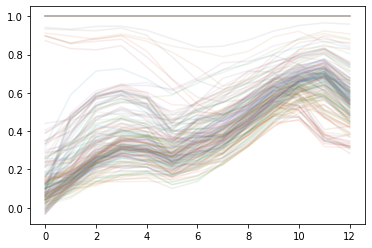

In [268]:
for key, d in distance_evolution.items():
    plt.plot(d, alpha=0.05)

tensor(2.7560) tensor(-4.2302)
argmax, argmin tensor(246) tensor(147)


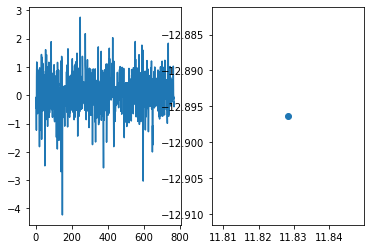

tensor(2.3937) tensor(-10.4819)
argmax, argmin tensor(572) tensor(147)


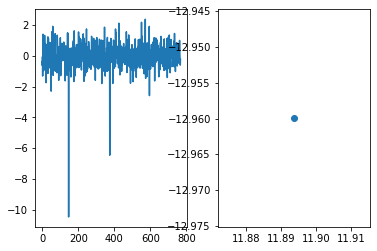

tensor(2.0245) tensor(-12.0507)
argmax, argmin tensor(426) tensor(147)


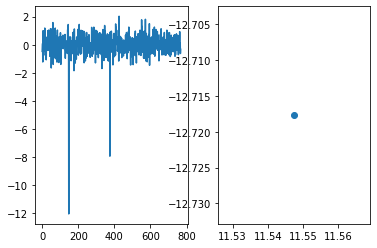

tensor(2.0096) tensor(-12.3038)
argmax, argmin tensor(551) tensor(147)


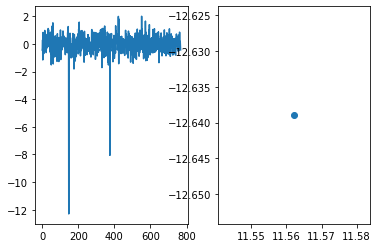

tensor(3.3066) tensor(-11.7994)
argmax, argmin tensor(422) tensor(147)


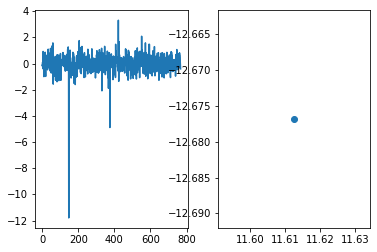

tensor(6.6751) tensor(-9.0022)
argmax, argmin tensor(422) tensor(147)


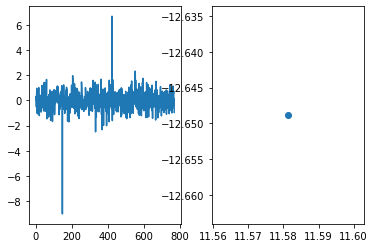

tensor(9.7968) tensor(-4.7424)
argmax, argmin tensor(422) tensor(147)


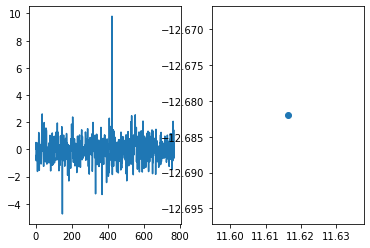

tensor(10.9334) tensor(-3.3298)
argmax, argmin tensor(422) tensor(367)


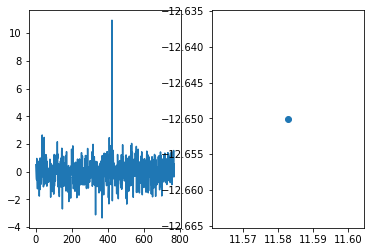

tensor(12.6292) tensor(-3.3535)
argmax, argmin tensor(422) tensor(367)


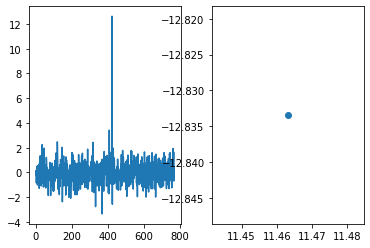

tensor(15.7930) tensor(-2.8324)
argmax, argmin tensor(422) tensor(367)


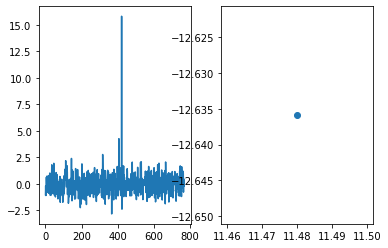

tensor(16.6719) tensor(-9.5717)
argmax, argmin tensor(422) tensor(193)


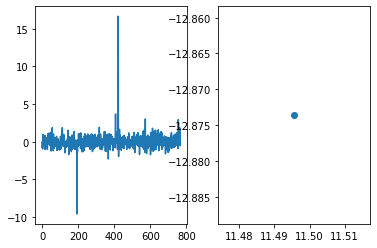

tensor(6.7100) tensor(-10.4582)
argmax, argmin tensor(422) tensor(193)


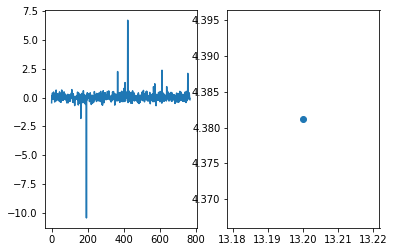

tensor(6.6776) tensor(-12.9609)
argmax, argmin tensor(422) tensor(193)


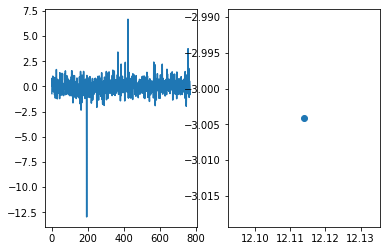

In [275]:
#### SEE EMBEDDING ACROSS LAYERS ####
token = 'the_2'
token2 = ''
for i in range(13):
    embedding = sentence.summary['token_embeddings'][token][i, :]#.clamp(-2, 2)
    u = fit.transform(torch.unsqueeze(embedding, 0))
    print(max(embedding), min(embedding))
    print('argmax, argmin', torch.argmax(embedding), torch.argmin(embedding))
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(embedding, alpha=1)
    axs[1].scatter(u[:,0], u[:,1])
    plt.show()
    #sentence.visualize_embedding(embedding)

In [276]:
# LOAD THE FIT OBJECT WITH ALL THE EMBEDDINGS FROM THE DATASET
fit = umap.UMAP(n_neighbors=10, n_components=2, metric='cosine', n_epochs=None, learning_rate=1.0, 
                init='spectral', min_dist=0.1, spread=1.0, set_op_mix_ratio=1.0, local_connectivity=1.0, 
                repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, 
                random_state=None, metric_kwds=None, angular_rp_forest=False, target_n_neighbors=-1, 
                target_metric='categorical', target_metric_kwds=None, target_weight=0.5, transform_seed=0, 
                verbose=False)
_ = fit.fit(ALL_EMBEDDINGS)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 24 separate connected components using meta-embedding (experimental)
  n_components


How do I determine the computational time complexity (Big-O) of back propagation in a feedforward neural network?
['[CLS]', 'how', 'do', 'i', 'determine', 'the', 'computational', 'time', 'complexity', '(', 'big', '-', 'o', ')', 'of', 'back', 'propagation', 'in', 'a', 'feedforward', 'neural', 'network', '?', '[SEP]']
['computational', 'time', 'complexity', 'neural', 'network']


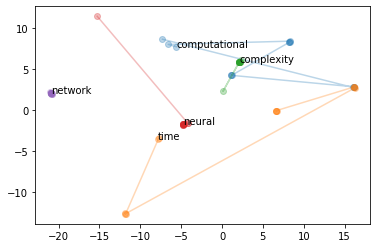

In [287]:
import numpy as np

sentence = scibert_sentences[34]
print(sentence.raw_string)
print(sentence.summary['input_tokens'])
sentence.visualize_token_path(fit, tokens_to_follow=['computational', 'time', 'complexity', 'neural', 'network'], 
                              print_tokens=True,
                             figsize=(15, 15))

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/animation.py", line 953, in _start
    self._init_draw()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/animation.py", line 1735, in _init_draw
    self._drawn_artists = self._init_func()
  File "<ipython-input-211-720756bb8326>", line 10, in init
    line.set_data([], [])
AttributeError: 'PathCollection' object has no attribute 'set_data'


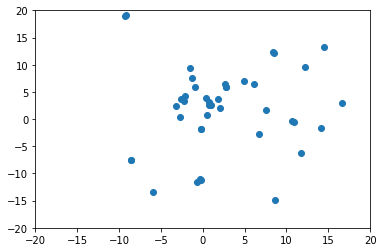

In [211]:
fig, ax = plt.subplots()
ax.set_xlim(( -20, 20))
ax.set_ylim((-20, 20))
scat = ax.scatter([], [])
array = data[0,:,:]
scat.set_offsets(array)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = data[:,i,0]
    y = data[:,i,1]
    s.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/animation.py", line 953, in _start
    self._init_draw()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/animation.py", line 1732, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/animation.py", line 1755, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-230-68d1f90625c5>", line 3, in update_plot
    print(aray.shape)
NameError: name 'aray' is not defined


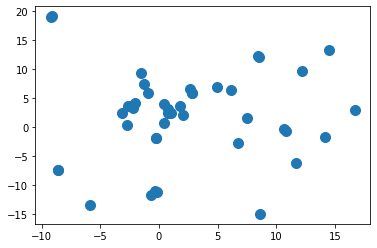

In [230]:
def update_plot(i):
    array = np.array([data[i, :, 0], data[i, :, 1]])
    print(aray.shape)
    scat.set_offsets(array)
    return scat,

numframes = 100
numpoints = len(sentence.summary['input_tokens'])
color_data = np.random.random((numframes, numpoints))
fig = plt.figure()
scat = plt.scatter(data[0, :, 0], data[0, :, 1], s=100)

ani = animation.FuncAnimation(fig, update_plot, frames=100, interval=100)
plt.show()


